In [ ]:
!pip install emoji
!pip install Sastrawi
!pip install transformers
!pip install scikit-learn
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Library
import nltk
nltk.download('punkt')

import emoji
import re
import random
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch import optim
from tqdm import tqdm
from tqdm.notebook import tqdm
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from transformers import BertConfig

# Load Dataset
stopword_path = '/content/drive/MyDrive/sentimen-bert-try/sentimen-bert-try/stopword.txt'
kamus_alay_path = '/content/drive/MyDrive/sentimen-bert-try/sentimen-bert-try/kamus_alay.csv'

df = pd.read_excel('/content/drive/MyDrive/sentimen-bert-try/train_label.xlsx')
df.head()

,text,label
0,Trus.... Masalah air kotor yg saya terima apa ...,air keruh
1,Knp debit air keruh ya,air keruh
2,air keruh dan bau dari 2 minggu yg lalu,air keruh
3,"Salam Sejahtera, saya dengan pelanggan 2161550...",air keruh
4,saya jika melihat tabel rumah saya lebih tepat...,air keruh


In [ ]:
df = df.dropna()

In [ ]:
jumlah_baris = len(df)
indeks_teracak = np.random.permutation(jumlah_baris)
df = df.iloc[indeks_teracak].reset_index(drop=True)

# Menyimpan data teracak ke file Excel baru
nama_file_excel = 'data_acak.xlsx'
df.to_excel(nama_file_excel, index=False)

In [ ]:
df['category'].value_counts()

label
TDA                  1445
meter                1131
pemakaian/tagihan     644
kebocoran             544
air keruh             487
layanan               170
apresiasi             128
tarif                 119
Name: count, dtype: int64

In [ ]:
possible_labels = df.label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'meter': 0,
 'air keruh': 1,
 'layanan': 2,
 'pemakaian/tagihan': 3,
 'kebocoran': 4,
 'TDA': 5,
 'tarif': 6,
 'apresiasi': 7}

In [ ]:
df['label'] = df.label.replace(label_dict)

In [ ]:
df

,text,label,labels
0,"meter mati lama sudah lapor tidak ada tanggapan ,",meter,0
1,"air berharii hari kotor dan bau selokan ,giman...",air keruh,1
2,sy terlambat mencatat di catat mandiri yg seha...,layanan,2
3,"air keruh sudah 1 bulan ,sudah melakukan keluh...",air keruh,1
4,meteran tidak berjalan atau berputar,meter,0
...,...,...,...
4663,meteran mati,meter,0
4664,Air mati,TDA,5
4665,air tidak keluar. sbelumnya air kotor kecoklatan,TDA,5
4666,mulai dari pemasangan bulan November akhir 202...,TDA,5


[1445, 1131, 644, 544, 487, 170, 128, 119]
['TDA', 'kebocoran', 'air keruh', 'pemakaian/tagihan', 'meter', 'layanan', 'tarif', 'apresiasi']


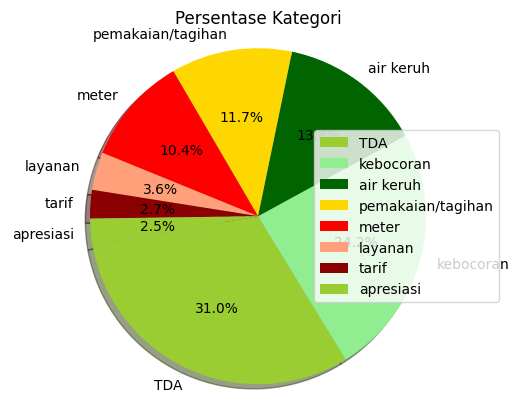

In [ ]:
sizes = df.label.value_counts()
category = ['TDA','kebocoran','air keruh','pemakaian/tagihan','meter','layanan','tarif','apresiasi']
colors = ['yellowgreen', 'lightgreen', 'darkgreen', 'gold', 'red', 'lightsalmon', 'darkred']
explode = (0, 0, 0, 0, 0, 0, 0, 0)

sizes = list(sizes)
print(sizes)
label = list(label)
# makeitastring = ''.join(map(str, label))
print(label)

plt.pie(sizes, explode=None, label=label, colors=colors, autopct='%1.1f%%', shadow=True, startangle=190)
#plt.pie(sizes, label, colors)
plt.axis('equal')
plt.title("Persentase Kategori")
plt.legend()
plt.show()

In [ ]:
# PreProcessing
## Preprocessing Tahap 1
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text):
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

def clean_text(text):
  text = text.lower() # ubah text menjadi huruf kecil
  text = re.sub(r'\n', ' ', text) # ubah enter menjadi spasi
  text = emoji.demojize(text) # hapus emoji
  text = re.sub(':[A-Za-z_-]+:', ' ', text) # delete emoji
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text) # hapus emoticon
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text) # hapus link
  text = re.sub(r"@[^\s]+[\s]?", ' ', text) # hapus usename
  text = re.sub(r'#(\S+)', r'\1', text) # hapus hashtag
  text = re.sub('[^a-zA-Z,.?!]+',' ',text) # hapus angka dan beberapa simbol
  text = repeatcharClean(text) # hapus karakter berulang
  text = re.sub('[ ]+',' ',text) # clear spasi
  return text

def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.text = df_pp.text.map(clean_text)

  # hapus baris kosong
  df_pp.text.replace('', np.nan, inplace=True)
  df_pp.text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['text'], inplace=True)
  return df_pp

df_v1 = preprocess_v1(df)

In [ ]:
## Preprocessing Tahap 2
# additional_stopword:list kata tdk penting
additional_stop = [] #['ya', 'deh', 'dia']
# default stopword
default_stop = pd.read_csv(stopword_path, sep='/n', names=['stopwords'])
default_stop = default_stop.stopwords.to_list()
# combine all stopword
list_stopwords = []
list_stopwords = default_stop + additional_stop
# remove specific stopword
# list_stopwords.remove("sangat")
# list_stopwords.remove("sekali")
kamus_alay = pd.read_csv(kamus_alay_path)

normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

def normalize_text(text):
  list_text = word_tokenize(text) # tokenisasi
  list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text] # ubah bahasa alay
  # stemming
  # factory = StemmerFactory()
  # stemmer = factory.create_stemmer()i
  # list_text = [stemmer.stem(word) for word in list_text]
  # hapus kata yang termasuk stopword
  # list_text = [word for word in list_text if word not in list_stopwords]
  text = " ".join(list_text) # gabung kembali kalimat
  return text

  def preprocess_v2(df):
  df_pp = df.copy()
  df_pp.text = df_pp.text.map(normalize_text)

  # hapus baris kosong
  df_pp.text.replace('', np.nan, inplace=True)
  df_pp.text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['text'], inplace=True)
  return df_pp

df  = preprocess_v2(df_v1)
df

<ipython-input-18-ecfa0a1cf06c>:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  default_stop = pd.read_csv(stopword_path, sep='/n', names=['stopwords'])


In [ ]:
# Splitting Data

X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df_grouped = df.groupby(['category', 'label', 'data_type']).count()
df_grouped = df_grouped.rename(columns={'text': 'jumlah_data'})
df_grouped

jumlah_data
label             labels data_type             
TDA               5      train             1228
                         val                217
air keruh         1      train              414
                         val                 73
apresiasi         7      train              109
                         val                 19
kebocoran         4      train              462
                         val                 82
layanan           2      train              145
                         val                 25
meter             0      train              961
                         val                170
pemakaian/tagihan 3      train              547
                         val                 97
tarif             6      train              101
                         val                 18

In [ ]:
#

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].labels.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].labels.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
seed_val = 6
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':       batch[0],
                  'attention_mask':  batch[1],
                  'labels':          batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

cuda


In [ ]:
for epoch in tqdm(range(1, epochs + 1)):

    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)

    for batch in progress_bar:

        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)

        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        outputs = model(**inputs)  # feed bert our inputs

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()  # back propagation step

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # step optimizer & scheduler
        optimizer.step()
        scheduler.step()

        # update progress bar and end batch loop
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})  # loss of current item / batch length

    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

# Save the model after training completes
model.save_pretrained('Models/BERT_ft_final.model')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1323 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9335448038049792
Validation loss: 0.7785949788163774
F1 Score (weighted): 0.8187503864349799


Epoch 2:   0%|          | 0/1323 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.6030981975853251
Validation loss: 0.7170637144147952
F1 Score (weighted): 0.840316091432755


Epoch 3:   0%|          | 0/1323 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.4937073676904997
Validation loss: 0.7583977239292004
F1 Score (weighted): 0.8503877076641181


Epoch 4:   0%|          | 0/1323 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.4031982482564956
Validation loss: 0.7419023291848632
F1 Score (weighted): 0.8501955593928264


Epoch 5:   0%|          | 0/1323 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.3370861104094351
Validation loss: 0.7532362591158838
F1 Score (weighted): 0.85687247621215


In [ ]:
# Load the model
model = BertForSequenceClassification.from_pretrained(
    '/content/Models/BERT_ft_final.model',  # Provide the directory path
    num_labels=len(label_dict),
    output_attentions=False,
    output_hidden_states=False
)

model.to(device)

_, predictions, true_vals = evaluate(dataloader_validation)

accuracy_per_class(predictions, true_vals)


Class: meter
Accuracy: 144/170

Class: air keruh
Accuracy: 65/73

Class: layanan
Accuracy: 17/25

Class: pemakaian/tagihan
Accuracy: 70/97

Class: kebocoran
Accuracy: 73/82

Class: TDA
Accuracy: 206/217

Class: tarif
Accuracy: 13/18

Class: apresiasi
Accuracy: 14/19



In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Load the pre-trained model with ignore_mismatched_sizes=True
model_path = '/content/drive/MyDrive/sentimen-bert-try/BERT_ft_final.model'
model = BertForSequenceClassification.from_pretrained(
    model_path,
    num_labels=8,  # Specify the correct number of labels
    output_attentions=False,
    output_hidden_states=False,
    ignore_mismatched_sizes=True  # Ignore size mismatches
)

# Create the text classification pipeline with the loaded model and tokenizer
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# run model

In [ ]:
label_map = {'LABEL_0': 'meter', 'LABEL_1': 'air keruh', 'LABEL_2': "layanan", 'LABEL_3': "pemakaian/tagihan",
             'LABEL_4': "kebocoran", 'LABEL_5': "TDA", 'LABEL_6': "tarif", 'LABEL_7': "apresiasi"}

result = classifier("terimakasih ya min")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: apresiasi


In [ ]:
result = classifier("min, air di rumah ku mampet")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: TDA


In [ ]:
result = classifier("oalah walikotae isok olahraga senyam senyum ketawa ketiwi. tapi wargae menjerit gk onok banyu gae ados lelet temen kerjoe pdam")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: apresiasi


In [ ]:
result = classifier("air tidak keluar . sbelumnya air kotor kecoklatan")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: TDA


In [ ]:
result = classifier("Tagihan saya kok membengkak bulan ini")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: pemakaian/tagihan


In [ ]:
result = classifier("airnya warna hijau kaya matcha")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: air keruh


In [ ]:
result = classifier("makasi yaa pdam skrg airku uda nyala bening lagi hihi")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: apresiasi


In [ ]:
result = classifier("kode tarif ga sesuai masa bulan kemarin 2.1 sekarang 2.3, aneh bener")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: tarif


In [ ]:
result = classifier("petugas PDAM tidak melakuan catat meter sesuai jadwal.")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: layanan


In [ ]:
result = classifier("ada kebocoran di pipa")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: kebocoran


In [ ]:
result = classifier("dari kemarin air tidak menyala di daerah sukolilo, biasanya jam segini sudah nyala. tolong diperbaiki kerjanya")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: TDA


In [ ]:
result = classifier("kata temenku air di rumahnya udah ga keluar 10 hari 10 malam, jadi dia gabisa mandi dan numpang di kos temen")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: TDA


In [ ]:
result = classifier("min PDAM ngagel bratang mati murup air e,mosok pipa nya putus sambung koyok hubungan tanpa status ae ðŸ˜‚")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: TDA


In [ ]:
result = classifier("Mosok yo bongkaran gorong2 maju 1 meter mesti pake acara pipo bocor min ?")

print("Predicted label:", label_map[result[0]['label']])
#print("Score:", round(result[0]['score'],3))

Predicted label: kebocoran
